In [64]:
import numpy as np
import matplotlib.pyplot as plt

from tyssue import PlanarGeometry
from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw, sheet_view
from tyssue.dynamics import effectors, factory
from tyssue.solvers.sheet_vertex_solver import Solver


## Ring points generation


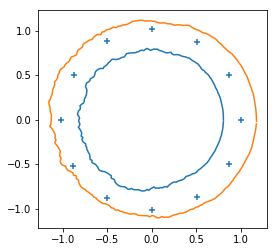

In [65]:
def make_noisy_ring(radius, noise_amp, n_points=256):
    thetas = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    noise = np.random.normal(scale=noise_amp, size=(n_points)).cumsum()
    noise *= np.sin(thetas/2)
    radius = radius + noise
    points = radius * np.vstack((np.cos(thetas), np.sin(thetas)))
    # recenter
    points -= points.mean(axis=1)[:, np.newaxis]
    # we transpose the result to have one coordinate pair per line
    return points.T

Nf = 12
R_in = 0.8
R_out = 1.2
inners = make_noisy_ring(R_in, 0.01)
outers = make_noisy_ring(R_out, 0.01)
centers = make_noisy_ring((R_in+R_out)/2, 0.01, Nf)
fig, ax = plt.subplots()
ax.plot(*inners.T)
ax.plot(*outers.T)
ax.scatter(centers[:, 0], centers[:, 1], marker='+')
_ = ax.set(aspect='equal')

## Bissection

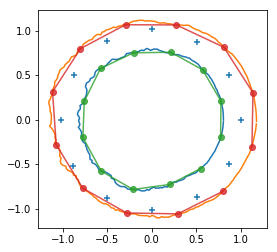

In [66]:
def find_closer_angle(theta0, theta1):
    '''Finds the index of the closest value in theta1
    for each value in theta0, with 2π periodic boundary
    conditions.
    
    Parameters
    ----------
    theta0 : np.ndarray of shape (N0,)
      the target values 
    theta1 : np.ndarray of shape (N1,)
      array where we search for the values closest
      to the targer theta0
      
    Returns
    -------
    indices : nd.array of shape (N0,)
      the indices of the values closest to theta0 in theta1
      
    Example
    -------
    >>> theta0 = np.array([0, 0.5, 0.79])*2*np.pi
    >>> theta1 = np.array([0, 0.1, 0.2, 0.4, 0.5, 0.8, 1.])*2*np.pi
    >>> find_closer_angle(theta0, theta1)
        np.array([0, 4, 5])
    '''
    tt0, tt1 = np.meshgrid(theta0, theta1)
    dtheta = tt0 - tt1
    # periodic boundary
    dtheta[dtheta >   np.pi] -= 2*np.pi
    dtheta[dtheta <= -np.pi] += 2*np.pi
    
    return (dtheta**2).argmin(axis=0)

def get_bissecting_vertices(centers, inners, outers):
    '''Docstring left as an exercice
    '''
    theta_centers = np.arctan2(centers[:, 1], centers[:, 0])
    bissect = (theta_centers + np.roll(theta_centers, 1, axis=0))/2
    dtheta = (theta_centers - np.roll(theta_centers, 1, axis=0))
    # periodic boundary
    bissect[dtheta >= np.pi] -= np.pi
    bissect[dtheta < -np.pi] += np.pi
    
    theta_inners = np.arctan2(inners[:, 1], inners[:, 0])
    theta_outers = np.arctan2(outers[:, 1], outers[:, 0])

    inner_vs = inners.take(find_closer_angle(bissect, theta_inners), axis=0)
    outer_vs = outers.take(find_closer_angle(bissect, theta_outers), axis=0)
    return inner_vs, outer_vs


inner_vs, outer_vs = get_bissecting_vertices(centers, inners, outers)
    
fig, ax = plt.subplots()
ax.plot(*inners.T)
ax.plot(*outers.T)
ax.scatter(centers[:, 0], centers[:, 1], marker='+')
ax.plot(inner_vs[:, 0], inner_vs[:, 1], '-o', alpha=0.8)
ax.plot(outer_vs[:, 0], outer_vs[:, 1], '-o', alpha=0.8)
_ = ax.set(aspect='equal')

## Generation of the annular tissue and adjustement to the data


We create a `AnnularSheet` object to model the tissue. 
![Organisation of an annular mesh representing the organoid](annular.svg)


The apical face is the one facing inside the ring, the basal outside. The `AnnularSheet` class provides
methods to index specificaly the apical and basal vertices, and the apical, basal and lateral edges. For example,
`organo.apical_verts` provides an index over the vertices 0 to 11 in the above drawing.

For reference, the code to generate the above figure is given bellow:

```python
organo = generate_ring(Nf, R_in, R_out, apical='in')
PlanarGeometry.update_all(organo)

fig, ax = sheet_view(organo,
                     edge={'head_width': 4, 'line_width':2},
                     vert={'visible': False})

organo.vert_df["theta"] = np.arctan2(organo.vert_df.y,
                                     organo.vert_df.x)

for i, vert in organo.vert_df.iterrows():

    dr = -10 if vert.segment == 'apical' else 10
    ax.text(vert.x + dr*np.cos(vert.theta),
            vert.y + dr*np.sin(vert.theta), str(i))
    
ax.grid()
ax.set_axis_off()
fig.set_size_inches(6, 6)
plt.savefig('annular.svg')
```

Adjusting the mesh to our data points requires only to atribute the positions of the vertices to the data points: 


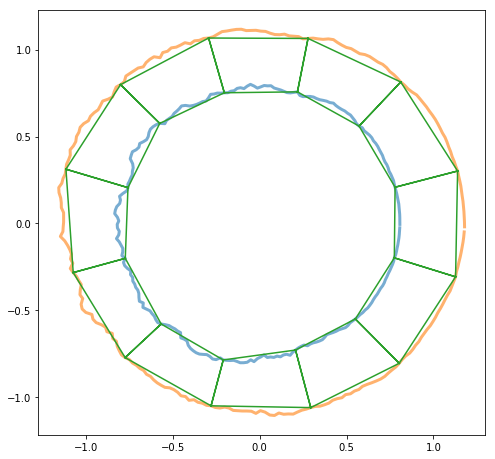

In [67]:
organo = generate_ring(Nf, R_in, R_out)

# adjustement
organo.vert_df.loc[organo.apical_verts, organo.coords] = inner_vs[::-1]
organo.vert_df.loc[organo.basal_verts, organo.coords] = outer_vs[::-1]

# Geometry update
PlanarGeometry.update_all(organo)
# Plot
fig, ax = plt.subplots()
ax.plot(*inners.T, lw=3, alpha=0.6)
ax.plot(*outers.T, lw=3, alpha=0.6)

fig, ax = quick_edge_draw(organo, ax=ax)
fig.set_size_inches(8, 8)
ax.set(aspect='equal');

## Simple model

We use a minimal model of the tissue with an energy as:

$$E = \sum_\alpha \frac{K_\alpha}{2}(A_\alpha - A_\alpha^0)^2 + \sum_{i,j} \Lambda_{ij}\ell_{ij}$$

Where the first sum is over the faces and the second is over the edges of the mesh, $A_\alpha$ is the area of cell $\alpha$ and $\ell_{ij}$ the length of the edge between vertices $i$ and $j$.




In [68]:
# Construction of the model
model = factory.model_factory(
    [effectors.FaceAreaElasticity,
     effectors.LineTension], 
    effectors.FaceAreaElasticity)
print('We build a model with the following terms:')
print('\t', *model.labels, sep='\n\t')

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area': organo.face_df.area.mean(),
        'area_elasticity': 1,},
    'edge':{
        'line_tension': 1e-3,
        'is_active': 1
        },
    'vert':{
        'is_active': 1
        },
    }


organo.update_specs(specs, reset=True)
energy = model.compute_energy(organo)
print(f'Computed enregy: {energy:.3f}')



Reseting datasets values with new specs


We build a model with the following terms:
	
	Area elasticity
	Line tension
Computed enregy: 0.011


In [71]:
origin = organo.copy()
target = origin.vert_df[['x', 'y']].copy()

minimize_opt = {'options':{'gtol':1e-15,
                           'ftol':1e-12}}

def cost(line_tensions):

    organo.edge_df['line_tension'] = line_tensions
    res = Solver.find_energy_min(organo, PlanarGeometry,
                                 model, minimize=minimize_opt)
    print(res["message"])
    new_pos = organo.vert_df[['x', 'y']]
    return ((target - new_pos).values**2).sum()
    



### Regular polygon model

We can work with a fully symetrical model to set the average values of the parameters $K_\alpha, A_\alpha^0$ and $\Lambda_{ij}$. We note those by droping the indices, except to differentiate between apical, basal and lateral segments for the edges, $K, A^0, \Lambda_a,\Lambda_b, \Lambda_l$

Let's assume that the mesh is perfectly circular, with $R_i$ and $R_o$ the inner and outer diameters, respectively, and $N_f$ the number of faces. 

We have:

$$ E_s = \frac{N_f K}{2}(A - A^0)^2 + N_f\Lambda_b\ell_b + N_f\Lambda_a\ell_a + 2N_f\Lambda_l\ell_l $$

We can normalise by dividing by $N_f$ and setting $K=1$ by definition:

$$ E_s/N_f = \epsilon_s = \frac{1}{2}(A - A^0)^2 + \Lambda_b\ell_b + \Lambda_a\ell_a + 2\Lambda_l\ell_l $$

The lengths of the lateral edges is $\ell_l = R_o - R_i$

The length of the basal and apical edges are the chord lengths:
$$
\ell_a = 2R_i\sin(\pi/N_f), \ell_b = 2R_o\sin(\pi/N_f)
$$

We can compute the area of the cell as it is a simple trapezoid whose height is $h = (R_o - R_i)\cos(\pi/N_f)/2$:
$$
A = \frac{h(\ell_a + \ell_b)}{2} = \frac{(R_o - R_i)}{2}\cos(\pi/N_f)(2R_o + 2R_i)\sin(\pi/N_f) = \frac{(R_o^2 - R_i^2)}{2}\sin(2\pi/N_f)
$$

#### Homogenous line tension case

If the line tension is the same for all the segments, we have:

$$
\epsilon_s = \frac{1}{2}\left(\frac{(R_o^2 - R_i^2)}{2}\sin(2\pi/N_f) - A^0\right)^2 + 2\Lambda\left((R_o - R_i) + (R_o + R_i)\sin(\pi/Nf)\right)
$$

The problem is then to look for the minimum of this experession as a function of $A^0$ and $\Lambda$.



In [ ]:
from math import sin, cos

def symmetric_energy(A_0, lbda, Nf, R_in, R_out):
    
    area = (R_out**2 - R_in**2) * sin(2*np.pi/Nf) / 2
    area_elasticity = 0.5 * (area - A_0)**2
    perimeter = 2*(R_out - R_in + (R_out + R_in) * sin(np.pi/Nf))
    line_tension = lbda**2 * perimeter
    
    return area_elasticity + line_tension

area_0 = (R_out**2 - R_in**2) * sin(2*np.pi/Nf) / 2
areas, tensions = np.meshgrid(np.linspace(0.5, 1.5, 128)*area_0,
                              np.linspace(-1e-3, 1e-3, 128))

energies = symmetric_energy(areas, tensions,
                            Nf, R_in, R_out)

fig, ax = plt.subplots()
ax.pcolorfast([areas.min(), areas.max()],
              [tensions.min(), tensions.max()], energies)
ax.set(xlabel='Prefered Area',
       ylabel='Line tension')

In [ ]:
energies.argmin()
